In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from tqdm.notebook import tqdm
import scipy.ndimage as ndi

In [ ]:
# Cursor parking space
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "./project.ipynb"

import wandb
wandb.login()

# wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})
def init_wandb(model, loss_function):
    wandb.init(project="Project", name="Wednesday", entity="cpl57")
    wandb.watch(model, loss_function, log="all")




wandb: Currently logged in as: barisimre (cpl57). Use `wandb login --relogin` to force relogin


In [ ]:
patient_folders = ["data/training/" + x + "/" for x in os.listdir("data/training")]
train_patients = patient_folders[:80]
test_patients = patient_folders[80:]

patient_files = [[x + y[:-7] for y in os.listdir(x) if "frame" in y and "gt" not in y] for x in train_patients]
patient_files_flattened = [element for sublist in patient_files for element in sublist]

test_patient_files = [[x + y[:-7] for y in os.listdir(x) if "frame" in y and "gt" not in y] for x in test_patients]
test_patient_files_flattened = [element for sublist in test_patient_files for element in sublist]


images = [{'img': x} for x in patient_files_flattened]
test_images = [{'img': x} for x in test_patient_files_flattened]

In [ ]:
from evaluate import load_nii
class LoadNIFTI(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        img_file = sample['img'] + ".nii.gz"
        img_mask = sample['img'] + "_gt.nii.gz"
        
        image, img_affine, img_header = load_nii(img_file)
        scale_dims = img_header['pixdim']
        
        
        image = np.moveaxis(image, (2), (0))
        
        mask, mask_affine, mask_header = load_nii(img_mask)
        mask = np.moveaxis(mask, (2), (0))
        
        return {'img': image, 'mask': mask, 'name': sample, 'scaling': scale_dims}
    
    
class SplitMask(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        mask = sample['mask'][0]
            
        c2 = np.where(np.logical_and(mask > 0.2, mask < 0.5), 1.0, 0.0)
        c3 = np.where(np.logical_and(mask > 0.5, mask < 0.8), 1.0, 0.0)
        c4 = np.where(mask > 0.8, 1.0, 0.0)
        sample['mask'] = np.array([c2, c3, c4])
        
        return sample
    
class ScaleDims(monai.transforms.Transform):
    def __init__(self, keys=None):
        pass
    
    def __call__(self, sample):
        scaling = sample['scaling']
        
        return monai.transforms.Zoomd(keys=['img', 'mask'], mode=['area', 'nearest'], zoom=(scaling[3] / 10, scaling[1] / 1.5, scaling[2] / 1.5), keep_size=False)(sample)
    
        # img = monai.transforms.Zoomd(keys=['img', 'mask']
        
class FindCenter(monai.transforms.Transform):
    def __init__(self, keys=None):
        self.model = monai.networks.nets.Unet(
                spatial_dims=3,
                in_channels=1,
                out_channels=3,
                channels = (8, 16, 32, 64),
                strides=(1, 1, 1),
                num_res_units=2,
            ).to(device)
        
        self.model.load_state_dict(torch.load("models/trainedUNet1655808833.8215299_24.pt"))
        self.model.eval()
        
    def __call__(self, sample):
        img = sample['img']
        with torch.no_grad():
            out = self.model(torch.unsqueeze(torch.Tensor(img).to(device), dim=0))
            combined = np.sum(out[0].detach().cpu().numpy(), axis=(0, 1))
            cx, cy = ndi.center_of_mass(combined)
            dim_height = out.shape[2]
            return monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(dim_height, 128, 128), roi_center=(dim_height // 2, int(cx), int(cy)))(sample)

        


In [ ]:
# Define transforms for loading the dataset

# add_channels_transform = monai.transforms.AddChanneld(keys=['img', 'mask'])
# flip_transform = monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1, spatial_axis=1)
# rotate_transform = monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest'])

compose_transform = monai.transforms.Compose(
    [
        LoadNIFTI(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img', 'mask'], minv=0.0, maxv=1.0),
        SplitMask(),
        monai.transforms.ScaleIntensityd(keys=['mask'], minv=0.0, maxv=1.0),
        ScaleDims(),
        FindCenter(),
        monai.transforms.RandRotated(keys=['img', 'mask'], range_x=np.pi/4, prob=1, mode=['bilinear', 'nearest']),
        monai.transforms.RandZoomd(keys=['img', 'mask'], prob=0.5, mode=['area', 'nearest']),
        monai.transforms.RandGridDistortiond(keys=['img', 'mask'], mode=['bilinear', 'nearest']),
        # monai.transforms.SpatialPadd(keys=['img', 'mask'], spatial_size=(16, -1, -1)),
        monai.transforms.RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=1)
        # monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(16, 128, 128), roi_center=(8, 64, 64)),
    ]
)

test_transform = monai.transforms.Compose(
    [
        LoadNIFTI(),
        monai.transforms.AddChanneld(keys=['img', 'mask']),
        monai.transforms.ScaleIntensityd(keys=['img', 'mask'], minv=0.0, maxv=1.0),
        SplitMask(),
        ScaleDims(),
        FindCenter(),
        # monai.transforms.SpatialPadd(keys=['img', 'mask'], spatial_size=(16, -1, -1)),
        # monai.transforms.Resized(keys=['img', 'mask'], spatial_size=(-1, 128, 128)),
        # monai.transforms.SpatialCropd(keys=['img', 'mask'], roi_size=(16, 128, 128), roi_center=(8, 64, 64)),

        monai.transforms.ScaleIntensityd(keys=['mask'], minv=0.0, maxv=1.0)
    ]
)


In [ ]:
train_dict_list = [x for x in images]
dataset = monai.data.CacheDataset(train_dict_list, transform=compose_transform)
test_dict_list = [x for x in test_images]
test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)


Loading dataset:   0%|          | 0/160 [00:00<?, ?it/s]

torch.Size([1, 3, 11, 175, 233])torch.Size([1, 3, 8, 246, 169])
torch.Size([1, 3, 8, 246, 169])



Loading dataset:   6%|▌         | 9/160 [00:01<00:23,  6.52it/s]

(175, 233)
(246, 169)
torch.Size([1, 3, 8, 266, 266])
torch.Size([1, 3, 8, 266, 266])
(246, 169)
torch.Size([1, 3, 10, 211, 233])
(266, 266)
(266, 266)
torch.Size([1, 3, 10, 211, 233])
torch.Size([1, 3, 11, 175, 233])
(211, 233)
(211, 233)
(175, 233)
torch.Size([1, 3, 10, 213, 253])
(213, 253)
torch.Size([1, 3, 8, 243, 299])
torch.Size([1, 3, 10, 213, 253])


Loading dataset:  11%|█         | 17/160 [00:02<00:15,  9.37it/s]

(243, 299)
(213, 253)
torch.Size([1, 3, 8, 216, 266])
torch.Size([1, 3, 8, 243, 299])
(216, 266)
torch.Size([1, 3, 8, 213, 253])
torch.Size([1, 3, 8, 213, 253])
torch.Size([1, 3, 8, 216, 266])
(243, 299)
(213, 253)
(213, 253)
(216, 266)
torch.Size([1, 3, 10, 268, 286])
(268, 286)
torch.Size([1, 3, 10, 208, 246])
torch.Size([1, 3, 10, 268, 286])


Loading dataset:  12%|█▎        | 20/160 [00:03<00:17,  7.91it/s]

(208, 246)
(268, 286)
torch.Size([1, 3, 7, 199, 266])
torch.Size([1, 3, 7, 187, 240])
(199, 266)
torch.Size([1, 3, 7, 187, 240])
(187, 240)
torch.Size([1, 3, 10, 208, 246])
torch.Size([1, 3, 7, 199, 266])
(187, 240)
(208, 246)
(199, 266)
torch.Size([1, 3, 9, 225, 266])
(225, 266)
torch.Size([1, 3, 8, 225, 266])
torch.Size([1, 3, 8, 225, 266])
torch.Size([1, 3, 6, 189, 233])


Loading dataset:  16%|█▋        | 26/160 [00:03<00:15,  8.78it/s]

(225, 266)
(189, 233)
torch.Size([1, 3, 9, 225, 266])
(225, 266)
torch.Size([1, 3, 6, 189, 233])
(225, 266)
torch.Size([1, 3, 9, 266, 225])
(189, 233)
(266, 225)
torch.Size([1, 3, 9, 266, 225])
(266, 225)
torch.Size([1, 3, 7, 222, 286])
(222, 286)
torch.Size([1, 3, 10, 233, 196])
torch.Size([1, 3, 7, 222, 286])
torch.Size([1, 3, 8, 266, 266])


Loading dataset:  26%|██▌       | 41/160 [00:04<00:08, 14.78it/s]

(233, 196)
(266, 266)
torch.Size([1, 3, 6, 256, 279])
(222, 286)
(256, 279)
torch.Size([1, 3, 8, 266, 266])
torch.Size([1, 3, 6, 256, 279])
(266, 266)
torch.Size([1, 3, 10, 233, 196])
(256, 279)
(233, 196)
torch.Size([1, 3, 6, 183, 266])
torch.Size([1, 3, 6, 183, 266])
(183, 266)
(183, 266)


Loading dataset:  28%|██▊       | 44/160 [00:04<00:10, 11.24it/s]

torch.Size([1, 3, 9, 233, 196])
torch.Size([1, 3, 10, 244, 279])
torch.Size([1, 3, 10, 244, 279])
torch.Size([1, 3, 9, 233, 196])
(244, 279)
(233, 196)
(233, 196)
(244, 279)
torch.Size([1, 3, 10, 191, 266])
torch.Size([1, 3, 10, 191, 266])
(191, 266)
(191, 266)
torch.Size([1, 3, 10, 233, 196])


Loading dataset:  31%|███       | 49/160 [00:05<00:07, 13.91it/s]

(233, 196)
torch.Size([1, 3, 10, 233, 196])
(233, 196)
torch.Size([1, 3, 9, 202, 240])
torch.Size([1, 3, 9, 202, 240])


Loading dataset:  36%|███▌      | 57/160 [00:05<00:07, 14.70it/s]

torch.Size([1, 3, 8, 200, 240])
(202, 240)
(202, 240)
torch.Size([1, 3, 8, 200, 240])
(200, 240)
torch.Size([1, 3, 8, 189, 266])
(200, 240)
torch.Size([1, 3, 8, 189, 266])
(189, 266)
(189, 266)
torch.Size([1, 3, 10, 205, 253])
torch.Size([1, 3, 10, 205, 253])
(205, 253)
(205, 253)
torch.Size([1, 3, 11, 271, 300])
(271, 300)
torch.Size([1, 3, 7, 195, 233])
torch.Size([1, 3, 11, 271, 300])


Loading dataset:  38%|███▊      | 60/160 [00:06<00:10,  9.27it/s]

(195, 233)
torch.Size([1, 3, 10, 277, 280])
torch.Size([1, 3, 10, 277, 280])
torch.Size([1, 3, 7, 195, 233])
(271, 300)
(277, 280)
(277, 280)
(195, 233)
torch.Size([1, 3, 10, 225, 266])


Loading dataset:  41%|████      | 65/160 [00:06<00:08, 11.41it/s]

(225, 266)
torch.Size([1, 3, 10, 225, 266])
(225, 266)
torch.Size([1, 3, 7, 187, 233])
(187, 233)
torch.Size([1, 3, 9, 218, 233])


Loading dataset:  42%|████▎     | 68/160 [00:07<00:10,  9.15it/s]

torch.Size([1, 3, 9, 218, 233])
(218, 233)
(218, 233)
torch.Size([1, 3, 10, 216, 266])
torch.Size([1, 3, 10, 216, 266])
torch.Size([1, 3, 7, 187, 233])
(216, 266)
(216, 266)
(187, 233)
torch.Size([1, 3, 10, 208, 246])
torch.Size([1, 3, 10, 208, 246])
(208, 246)
(208, 246)
torch.Size([1, 3, 10, 266, 266])
torch.Size([1, 3, 10, 266, 266])


Loading dataset:  47%|████▋     | 75/160 [00:07<00:07, 10.83it/s]

(266, 266)
torch.Size([1, 3, 8, 216, 266])
(266, 266)
(216, 266)
torch.Size([1, 3, 8, 216, 266])
(216, 266)
torch.Size([1, 3, 8, 208, 246])
torch.Size([1, 3, 8, 208, 246])
(208, 246)
(208, 246)
torch.Size([1, 3, 10, 226, 233])


Loading dataset:  51%|█████     | 81/160 [00:08<00:06, 12.18it/s]

(226, 233)
torch.Size([1, 3, 10, 226, 233])
(226, 233)
torch.Size([1, 3, 7, 187, 233])
torch.Size([1, 3, 7, 187, 233])
torch.Size([1, 3, 7, 180, 213])
(187, 233)
(180, 213)
(187, 233)
torch.Size([1, 3, 7, 180, 213])
(180, 213)
torch.Size([1, 3, 10, 225, 266])


Loading dataset:  56%|█████▌    | 89/160 [00:08<00:05, 13.91it/s]

(225, 266)
torch.Size([1, 3, 10, 225, 266])
(225, 266)
torch.Size([1, 3, 9, 233, 196])
(233, 196)
torch.Size([1, 3, 9, 233, 196])
torch.Size([1, 3, 9, 233, 196])
(233, 196)
(233, 196)
torch.Size([1, 3, 9, 233, 196])


Loading dataset:  57%|█████▊    | 92/160 [00:08<00:05, 12.12it/s]

torch.Size([1, 3, 5, 233, 195])
(233, 196)
torch.Size([1, 3, 5, 233, 195])
(233, 195)
(233, 195)
torch.Size([1, 3, 10, 233, 266])
torch.Size([1, 3, 8, 213, 253])
(233, 266)
torch.Size([1, 3, 10, 233, 266])
(213, 253)
(233, 266)
torch.Size([1, 3, 8, 213, 253])


Loading dataset:  62%|██████▎   | 100/160 [00:09<00:04, 13.78it/s]

(213, 253)
torch.Size([1, 3, 9, 195, 233])
(195, 233)
torch.Size([1, 3, 10, 233, 196])
(233, 196)
torch.Size([1, 3, 10, 233, 196])
torch.Size([1, 3, 9, 195, 233])
(195, 233)
(233, 196)
torch.Size([1, 3, 9, 225, 266])
torch.Size([1, 3, 9, 225, 266])


Loading dataset:  64%|██████▍   | 103/160 [00:09<00:04, 12.96it/s]

(225, 266)
(225, 266)
torch.Size([1, 3, 10, 189, 233])
torch.Size([1, 3, 10, 189, 233])
(189, 233)
(189, 233)
torch.Size([1, 3, 6, 232, 286])


Loading dataset:  68%|██████▊   | 109/160 [00:10<00:03, 13.72it/s]

(232, 286)
torch.Size([1, 3, 6, 232, 286])
(232, 286)
torch.Size([1, 3, 10, 200, 266])
(200, 266)
torch.Size([1, 3, 10, 200, 266])
(200, 266)
torch.Size([1, 3, 6, 216, 266])
(216, 266)
torch.Size([1, 3, 6, 216, 266])


Loading dataset:  70%|███████   | 112/160 [00:10<00:03, 15.50it/s]

(216, 266)
torch.Size([1, 3, 10, 250, 266])


Loading dataset:  71%|███████▏  | 114/160 [00:10<00:03, 11.53it/s]

torch.Size([1, 3, 10, 250, 266])
(250, 266)
torch.Size([1, 3, 8, 262, 280])
(250, 266)
(262, 280)
torch.Size([1, 3, 8, 262, 280])
(262, 280)
torch.Size([1, 3, 10, 208, 246])


Loading dataset:  75%|███████▌  | 120/160 [00:10<00:02, 15.04it/s]

(208, 246)
torch.Size([1, 3, 10, 208, 246])
(208, 246)
torch.Size([1, 3, 8, 196, 233])
torch.Size([1, 3, 8, 196, 233])
(196, 233)
(196, 233)
torch.Size([1, 3, 7, 233, 196])


Loading dataset:  78%|███████▊  | 125/160 [00:11<00:02, 16.19it/s]

(233, 196)
torch.Size([1, 3, 8, 233, 160])
torch.Size([1, 3, 8, 233, 160])
(233, 160)
(233, 160)
torch.Size([1, 3, 7, 233, 196])
torch.Size([1, 3, 9, 233, 233])
(233, 196)
torch.Size([1, 3, 9, 233, 233])
(233, 233)
(233, 233)


Loading dataset:  79%|███████▉  | 127/160 [00:11<00:02, 14.06it/s]

torch.Size([1, 3, 9, 196, 233])
(196, 233)
torch.Size([1, 3, 9, 196, 233])
torch.Size([1, 3, 7, 183, 266])
(196, 233)
(183, 266)
torch.Size([1, 3, 7, 183, 266])


Loading dataset:  83%|████████▎ | 133/160 [00:11<00:01, 14.08it/s]

(183, 266)
torch.Size([1, 3, 10, 196, 233])
torch.Size([1, 3, 10, 196, 233])
(196, 233)
(196, 233)
torch.Size([1, 3, 10, 208, 266])
torch.Size([1, 3, 10, 208, 266])
(208, 266)
(208, 266)
torch.Size([1, 3, 9, 213, 253])
(213, 253)
torch.Size([1, 3, 10, 240, 202])


Loading dataset:  85%|████████▌ | 136/160 [00:12<00:02, 11.79it/s]

(240, 202)
torch.Size([1, 3, 9, 213, 253])
torch.Size([1, 3, 10, 240, 202])
(213, 253)
(240, 202)
torch.Size([1, 3, 8, 246, 177])
(246, 177)
torch.Size([1, 3, 8, 246, 177])
(246, 177)
torch.Size([1, 3, 8, 183, 266])
(183, 266)
torch.Size([1, 3, 10, 196, 233])
torch.Size([1, 3, 8, 183, 266])


Loading dataset:  91%|█████████ | 145/160 [00:12<00:01, 14.60it/s]

(183, 266)
(196, 233)
torch.Size([1, 3, 10, 196, 233])
(196, 233)
torch.Size([1, 3, 8, 216, 266])
(216, 266)
torch.Size([1, 3, 8, 216, 266])
(216, 266)
torch.Size([1, 3, 10, 184, 246])
(184, 246)
torch.Size([1, 3, 10, 184, 246])


Loading dataset:  92%|█████████▎| 148/160 [00:13<00:00, 13.03it/s]

(184, 246)
torch.Size([1, 3, 10, 233, 266])
(233, 266)
torch.Size([1, 3, 7, 149, 233])
torch.Size([1, 3, 8, 196, 233])
(196, 233)
(149, 233)
torch.Size([1, 3, 10, 233, 266])
(233, 266)
torch.Size([1, 3, 7, 149, 233])
(149, 233)
torch.Size([1, 3, 8, 196, 233])


Loading dataset:  96%|█████████▋| 154/160 [00:13<00:00, 16.08it/s]

(196, 233)
torch.Size([1, 3, 7, 200, 266])
(200, 266)
torch.Size([1, 3, 7, 200, 266])
(200, 266)
torch.Size([1, 3, 7, 196, 233])
(196, 233)
torch.Size([1, 3, 7, 196, 233])


Loading dataset: 100%|██████████| 160/160 [00:13<00:00, 11.84it/s]


(196, 233)
torch.Size([1, 3, 9, 208, 246])
torch.Size([1, 3, 9, 208, 246])
(208, 246)
(208, 246)


Loading dataset:   0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([1, 3, 9, 286, 232])
torch.Size([1, 3, 6, 253, 299])
(286, 232)
torch.Size([1, 3, 6, 253, 299])
(253, 299)
(253, 299)
torch.Size([1, 3, 8, 266, 183])


Loading dataset:   2%|▎         | 1/40 [00:00<00:26,  1.48it/s]

(266, 183)
torch.Size([1, 3, 8, 266, 183])
torch.Size([1, 3, 9, 286, 232])
(286, 232)
torch.Size([1, 3, 7, 266, 216])
(266, 183)
(266, 216)
torch.Size([1, 3, 7, 266, 216])
(266, 216)
torch.Size([1, 3, 9, 227, 279])
torch.Size([1, 3, 9, 227, 279])


Loading dataset:  22%|██▎       | 9/40 [00:00<00:02, 12.28it/s]

(227, 279)
(227, 279)
torch.Size([1, 3, 8, 153, 213])
(153, 213)
torch.Size([1, 3, 7, 227, 280])
torch.Size([1, 3, 8, 153, 213])
torch.Size([1, 3, 7, 227, 280])


Loading dataset:  30%|███       | 12/40 [00:01<00:02, 11.09it/s]

(227, 280)
(153, 213)
(227, 280)
torch.Size([1, 3, 9, 196, 233])
(196, 233)
torch.Size([1, 3, 9, 196, 233])
(196, 233)
torch.Size([1, 3, 7, 225, 266])


Loading dataset:  42%|████▎     | 17/40 [00:01<00:01, 13.89it/s]

(225, 266)
torch.Size([1, 3, 9, 253, 213])
torch.Size([1, 3, 9, 253, 213])
(253, 213)
(253, 213)
torch.Size([1, 3, 8, 213, 253])
torch.Size([1, 3, 10, 211, 233])
torch.Size([1, 3, 7, 225, 266])


Loading dataset:  62%|██████▎   | 25/40 [00:02<00:00, 15.17it/s]

(213, 253)
(225, 266)
torch.Size([1, 3, 10, 211, 233])
(211, 233)
torch.Size([1, 3, 8, 213, 253])
(211, 233)
(213, 253)
torch.Size([1, 3, 9, 271, 300])
(271, 300)
torch.Size([1, 3, 8, 187, 233])
torch.Size([1, 3, 8, 187, 233])
torch.Size([1, 3, 9, 271, 300])


Loading dataset:  70%|███████   | 28/40 [00:02<00:01, 11.92it/s]

torch.Size([1, 3, 7, 270, 320])
(187, 233)
(187, 233)
(271, 300)
(270, 320)
torch.Size([1, 3, 7, 270, 320])
torch.Size([1, 3, 8, 169, 246])
(270, 320)
(169, 246)
torch.Size([1, 3, 8, 169, 246])


Loading dataset:  75%|███████▌  | 30/40 [00:02<00:00, 11.04it/s]

(169, 246)
torch.Size([1, 3, 11, 208, 246])
(208, 246)
torch.Size([1, 3, 11, 208, 246])
torch.Size([1, 3, 6, 216, 266])


Loading dataset: 100%|██████████| 40/40 [00:03<00:00, 12.99it/s]

(208, 246)
(216, 266)
torch.Size([1, 3, 6, 216, 266])
(216, 266)
torch.Size([1, 3, 8, 200, 240])
torch.Size([1, 3, 9, 196, 233])
(200, 240)
(196, 233)
torch.Size([1, 3, 9, 196, 233])
(196, 233)
torch.Size([1, 3, 8, 200, 240])
(200, 240)


In [ ]:
data_loader = monai.data.DataLoader(dataset, batch_size=1, shuffle=True)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

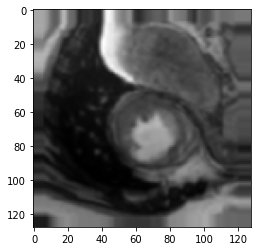

torch.Size([1, 3, 10, 128, 128])


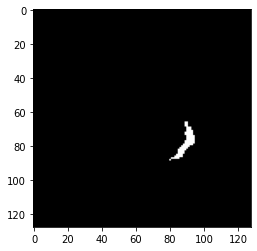

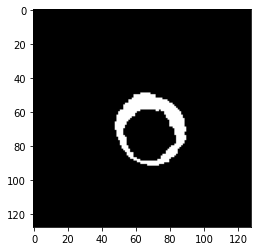

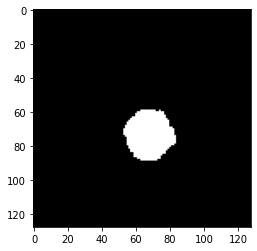

In [ ]:
# Visualize something
for data in data_loader:
    plt.imshow(data['img'][0][0][5], cmap='gray')
    plt.show()
    print(data['mask'].shape)
    plt.imshow(data['mask'][0][0][5], cmap='gray')
    plt.show()
    plt.imshow(data['mask'][0][1][5], cmap='gray')
    plt.show()
    plt.imshow(data['mask'][0][2][5], cmap='gray')
    break

In [ ]:
# UNet

In [ ]:
model = monai.networks.nets.Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels = (8, 16, 32, 64),
    strides=(1, 1, 1),
    num_res_units=2,
).to(device)

# model = monai.networks.nets.UNETR(in_channels=1, out_channels=3, img_size=(16,128,128), feature_size=32, norm_name='batch').to(device)

In [ ]:
loss_function = monai.losses.DiceLoss()

def intersection_loss(output):
    return ((1 - loss_function(output[0], output[1])) + (1 - loss_function(output[1], output[2])) + (1 - loss_function(output[0], output[2]))) / 3.0

# loss_function =  monai.losses.DiceCELoss(lambda_dice=1.0, lambda_ce=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
import time
run = wandb.init(project="Project", name="UNET", entity="cpl57", config={"TRAIN_SET": train_patients})
wandb.watch(model, loss_function, log_freq=10, log="all")

name = f'models/trainedUNet{str(time.time())}'

def flatten(xss):
    return [x for xs in xss for x in xs]

def createWandbImageArray(image, labels, masks):
    image = image[0]
    labels = np.clip(np.moveaxis(labels, (0), (1)), a_min=0.0, a_max=1.0)
    masks = np.round(np.clip(np.moveaxis(masks, (0), (1)), a_min=0.0, a_max=1.0))
    return [createWandbImage(i, l, m) for i, l, m in zip(image, labels, masks)]
    

def createWandbImage(image, labels, masks):    
    return wandb.Image(image, caption="Input", masks={
        "prediction0": {
            "mask_data": masks[0],
            "class_labels": {0: "Not there", 1: "There"}
        },
        "prediction1": {
            "mask_data": masks[1],
            "class_labels": {0: "Not there", 1: "There"}
        },
        "prediction2": {
            "mask_data": masks[2],
            "class_labels": {0: "Not there", 1: "There"}
        },
        
        "ground_truth0": {
            "mask_data": labels[0],
            "class_labels": {0: "Not there", 1: "There"}
        },
        "ground_truth1": {
            "mask_data": labels[1],
            "class_labels": {0: "Not there", 1: "There"}
        },
        "ground_truth2": {
            "mask_data": labels[2],
            "class_labels": {0: "Not there", 1: "There"}
        }
    })


def train(data):
    img = data['img']
    mask = data['mask']
    model.train()
    optimizer.zero_grad()
    output = torch.clamp(model(img.to(device)), min=0, max=1)
    loss = loss_function(output, mask.to(device))
    # loss = loss_function(output, mask.to(device)) + 0.3 * intersection_loss(output[0])
    loss.backward()
    optimizer.step()
    run.log( {'loss':loss.item()})
    return loss.item()    


    
def test(data):
    model.eval()
    img = data['img']
    mask = data['mask']
    output = torch.clamp(model(img.to(device)), min=0, max=1)
    loss = loss_function(output, mask.to(device))
    # loss = loss_function(output, mask.to(device)) + 0.3 * intersection_loss(output[0])

    test_loss.append(loss.item())
    test_img = img.detach().cpu().numpy()
    test_mask = mask.detach().cpu().numpy()
    test_out = output.detach().cpu().numpy()
    return loss.item(), test_img, test_mask, test_out
    
def wandb_images(img, mask, out):
    images = createWandbImageArray(img[0], mask[0], out[0])
    masks = flatten([[wandb.Image(np.clip(channel, a_min=0.0, a_max=1.0), caption="Label") for channel in x] for x in mask[0]])           
    outs = flatten([[wandb.Image(np.clip(channel, a_min=0.0, a_max=1.0), caption="Output") for channel in x] for x in out[0]]) 
    return images, masks, outs
    
    
i = 0
for epoch in tqdm(range(20000), colour="pink"):
    i += 1
    train_losses = []
    outputs = []
    torch.cuda.empty_cache()

    for data in tqdm(data_loader, colour="pink"):
        train_losses.append(train(data))

    if i % 8 == 0:
        
        torch.save(model.state_dict(), name+f"_{i}.pt")
    
    test_loss = []
    for data in test_loader:
        with torch.no_grad():
            loss, test_img, test_mask, test_out = test(data)
            test_loss.append(loss)
    
    for data in data_loader:
        with torch.no_grad():
            _, train_img, train_mask, train_out = test(data)
            break
        
    test_images, test_masks, test_outs = wandb_images(test_img, test_mask, test_out)
    train_images, train_masks, train_outs = wandb_images(train_img, train_mask, train_out)

        
    train_loss = sum(train_losses)/len(train_losses)
    test_l = sum(test_loss)/len(test_loss)
    
    
    # val_loss = sum(val_losses)/len(val_losses)
    run.log({'test_img': test_images, 'test_mask': test_masks, 'test_out': test_outs, 'train_img': train_images, 'train_mask': train_masks, 'train_out': train_outs, 'epoch':epoch, 'train_loss': train_loss, "test_loss": test_l}) 

        

    
run.finish()    


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

/usr/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /build/python-pytorch/src/pytorch-1.11.0-cuda/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]